# MLIB Lab

## 1. Spark ML introduction

In [1]:
#!pip install matplotlib-venn

In [2]:
import findspark
findspark.init("/home/alumno/spark-3.2.2-bin-hadoop2.7")
from pyspark import SparkContext, SparkConf
conf=SparkConf().setAppName("intro").setMaster("local")
sc = SparkContext(conf=conf)
from pyspark.sql import SparkSession
spark=SparkSession(sc)

In [3]:
! ls ml-latest-small

links.csv  movies.csv  ratings.csv  README.txt	tags.csv


In [4]:
movies_csv="ml-latest-small/movies.csv"
ratings_csv="ml-latest-small/ratings.csv"
moviesDF=spark.read.option("header","true").csv(movies_csv, inferSchema=True)
ratingsDF=spark.read.option("header","true").csv(ratings_csv, inferSchema=True)
moviesDF.printSchema()
ratingsDF.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



## 2. Join input DataFrames

In [5]:
features = ratingsDF.join(moviesDF, ["movieId"], "left")
features.summary().show()
features.printSchema()
features.show(10, truncate=False)

+-------+----------------+------------------+------------------+--------------------+--------------------+------------------+
|summary|         movieId|            userId|            rating|           timestamp|               title|            genres|
+-------+----------------+------------------+------------------+--------------------+--------------------+------------------+
|  count|          100836|            100836|            100836|              100836|              100836|            100836|
|   mean|19435.2957177992|326.12756356856676| 3.501556983616962|1.2059460873684695E9|                null|              null|
| stddev|35530.9871987003| 182.6184914635004|1.0425292390606342|2.1626103599513078E8|                null|              null|
|    min|               1|                 1|               0.5|           828124615|"11'09""01 - Sept...|(no genres listed)|
|    25%|            1199|               177|               3.0|          1018535155|                null|            

### Question 1: 
### Which one of the following options is correct regarding the requirements of ML algorithms in MLlib?
A: All columns can be used as features

B: Only the rating column can be used as feature because it's data type is Double

**C: movieId, userId, rating, and timestamp can all be used as features because their data type is numeric**

D: None of the above is correct

## 3. Preparation of input data for model building and testing

In [6]:
#We must split our input dataset into a training and validation separate sets to apply ML methods and latertest their prediction quality.
(trainDF, tempDF) = features.randomSplit([0.8, 0.2], seed=1)

### Question 2: 
### Draw the result of join operations left-semi and left-anti in a simple schema with two sets (red and yellow) with some elements in common:

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib_venn import venn2

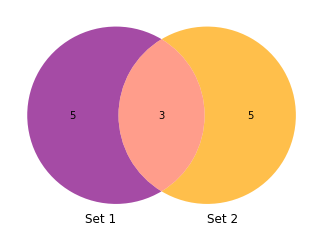

In [8]:
#we define 2 dataframes having some values in common
data1 = {'common_column': [1, 2, 3, 4, 5]}
data2 = {'common_column': [3, 4, 5, 6, 7]}
df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)

#convert to sets
set1 = set(df1['common_column'])
set2 = set(df2['common_column'])
intersection = set1.intersection(set2)

# Create a Venn diagram
venn_labels = {'100': 'Set 1', '010': 'Set 2', '110': 'Intersection'}

venn2(subsets=(len(set1), len(set2), len(intersection)),
      set_labels=('Set 1', 'Set 2'),
      ax=plt.gca(),
      set_colors=('purple', 'orange'),
      alpha=0.7,
      subset_label_formatter=lambda x: venn_labels.get(str(x), str(x)))

# Display the plot
plt.show()

In [9]:
validationDF = (
    tempDF
        .join(trainDF, ["userId"], "left_semi")
        .join(trainDF, ["movieId"], "left_semi")
)
nonMatch = tempDF.join(validationDF, ["movieId", "userId"], "left_anti")
trainDF = trainDF.union(nonMatch)

validationDF.printSchema()
features.count()
trainDF.count()
validationDF.count()

root
 |-- movieId: integer (nullable = true)
 |-- userId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



19533

In [10]:
#We can take an initial look at the shape of our data model with simple data visualizations:
trainDF.select("userId","movieId","rating").show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|   4.0|
|     5|      1|   4.0|
|     7|      1|   4.5|
|    15|      1|   2.5|
|    18|      1|   3.5|
|    19|      1|   4.0|
|    21|      1|   3.5|
|    27|      1|   3.0|
|    31|      1|   5.0|
|    32|      1|   3.0|
|    33|      1|   3.0|
|    40|      1|   5.0|
|    46|      1|   5.0|
|    54|      1|   3.0|
|    57|      1|   5.0|
|    63|      1|   5.0|
|    64|      1|   4.0|
|    66|      1|   4.0|
|    68|      1|   2.5|
|    71|      1|   5.0|
+------+-------+------+
only showing top 20 rows



Text(0.5, 0, 'Rating')

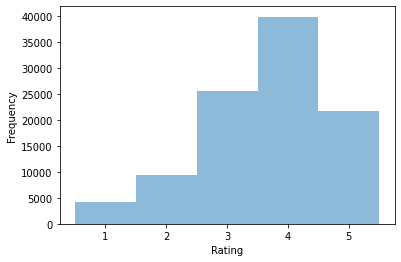

In [11]:
#Then, we can use Pandas to generate a basic plot of our ratings:
import matplotlib.pyplot as plt
import seaborn as sns
ratingPandas=ratingsDF.select("rating").collect()
ratingList=[ratingPandas[i][0] for i in range(len(ratingPandas))]
plt.hist(ratingList, bins=[0.5,1.5,2.5,3.5,4.5,5.5], alpha=0.5, histtype='stepfilled')
plt.ylabel('Frequency')
plt.xlabel('Rating')

## 4. Recommendation model: ALS matrix factorization model


In [12]:
from pyspark.ml.recommendation import ALS

In [13]:
#The ALS factorization algorithm works with "users", "products", and "ratings".
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating")

In [14]:
#After we have defined the parameters, we can train the model and compute the predictions to measure validationDF quality of prediction
model=als.fit(trainDF)
predDF=model.transform(validationDF)
predDF.show(truncate=False)

+-------+------+------+----------+----------------------------------------------------------------------------------------------+-------------------------------------------+----------+
|movieId|userId|rating|timestamp |title                                                                                         |genres                                     |prediction|
+-------+------+------+----------+----------------------------------------------------------------------------------------------+-------------------------------------------+----------+
|1      |471   |5.0   |1496671820|Toy Story (1995)                                                                              |Adventure|Animation|Children|Comedy|Fantasy|3.410008  |
|296    |463   |4.0   |1145460490|Pulp Fiction (1994)                                                                           |Comedy|Crime|Drama|Thriller                |4.1794853 |
|296    |471   |4.0   |1496671827|Pulp Fiction (1994)                      

In [15]:
# We will use R-squared evaluator to get an initial approximation on the quality of the model.
from pyspark.ml.evaluation import RegressionEvaluator
regEvaluator=RegressionEvaluator(predictionCol="prediction", labelCol="rating")
r2 = regEvaluator.setMetricName("r2").evaluate(predDF)
r2

0.2769229859955932

## 5. Generating item recommendations for users

In [16]:
# We could use the model to recommend the top 5 movies. We will generate pairs of movieId and rating for each user.
usersRec = model.recommendForAllUsers(5)
usersRec.printSchema()
usersRec.show(truncate=False)
usersRec.first()

/home/alumno/spark-3.2.2-bin-hadoop2.7/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


root
 |-- userId: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- movieId: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)

+------+----------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                     |
+------+----------------------------------------------------------------------------------------------------+
|1     |[{33649, 5.7230816}, {102217, 5.6277404}, {92494, 5.6277404}, {7842, 5.6249456}, {26471, 5.5704713}]|
|2     |[{6818, 4.914327}, {131724, 4.902197}, {3379, 4.7961197}, {96004, 4.7961197}, {5466, 4.7672853}]    |
|3     |[{86345, 5.5493836}, {6835, 4.928707}, {5746, 4.928707}, {5181, 4.877067}, {70946, 4.8262534}]      |
|4     |[{26171, 5.2140646}, {3742, 5.133888}, {971, 5.0970674}, {2318, 5.032909}, {876, 4.997677}]    

Row(userId=1, recommendations=[Row(movieId=33649, rating=5.723081588745117), Row(movieId=102217, rating=5.627740383148193), Row(movieId=92494, rating=5.627740383148193), Row(movieId=7842, rating=5.624945640563965), Row(movieId=26471, rating=5.570471286773682)])

In [17]:
# We are interested in selecting this first user and get best rated movie titles recommended from the model
from pyspark.sql.functions import col, explode, lit
user = usersRec.first().userId
movieRec1 = usersRec.filter(f"userId == {user}").withColumn("recs",explode("recommendations"))
movieRec2=movieRec1.select("userId", col("recs").movieId.alias("movieId"),col("recs").rating.alias("rating"))
movieRec=movieRec2.join(moviesDF, "movieId")
m=movieRec.orderBy("rating", descending=True).select("movieId", "title", "rating")
m.show(5)

+-------+--------------------+---------+
|movieId|               title|   rating|
+-------+--------------------+---------+
|  26471|Eddie Murphy Deli...|5.5704713|
|   7842|         Dune (2000)|5.6249456|
| 102217|Bill Hicks: Revel...|5.6277404|
|  92494|Dylan Moran: Mons...|5.6277404|
|  33649|  Saving Face (2004)|5.7230816|
+-------+--------------------+---------+



### Question 3: 
### Find the movies not rated by the previous user found. Consider that you can find all the ratings in ratingsDF. What information can we find there? What does it mean a user has not rated a particular movie?



In [18]:
ratingsDF.groupBy("userId")

In [19]:
from pyspark.sql.functions import expr
ratings_1 = ratingsDF.where(expr("userId = 1"))
ratings_1.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



In [20]:
no_user1_ratings = ratingsDF.join(ratings_1, ["movieId"], "left_anti").select('movieId')
no_user1_ratings.show(3)

+-------+
|movieId|
+-------+
|    318|
|   1704|
|   6874|
+-------+
only showing top 3 rows



In [21]:
no_user1_ratings.count()

84540

In [22]:
from pyspark.sql.functions import expr, desc, asc

In [23]:
no_user1_ratings_distinct = no_user1_ratings.distinct().orderBy(asc("movieId"))
total_not_rated = no_user1_ratings_distinct.count()
total_not_rated

9492

### Question 4: 
### Show the predicted rating for the unrated movies of question 3. Output should be similar to:

In [24]:
# We could use the model to recommend the top 5 movies. We will generate pairs of movieId and rating for each user.
user = usersRec.first().userId
usersRec = model.recommendForAllUsers(total_not_rated)
usersRec.printSchema()
usersRec.show(truncate=False)
usersRec.first()

root
 |-- userId: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- movieId: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Row(userId=1, recommendations=[Row(movieId=33649, rating=5.723081588745117), Row(movieId=102217, rating=5.627740383148193), Row(movieId=92494, rating=5.627740383148193), Row(movieId=7842, rating=5.624945640563965), Row(movieId=26471, rating=5.570471286773682), Row(movieId=3379, rating=5.540760517120361), Row(movieId=96004, rating=5.540760517120361), Row(movieId=33779, rating=5.5100789070129395), Row(movieId=1939, rating=5.485838413238525), Row(movieId=69524, rating=5.471005916595459), Row(movieId=5466, rating=5.401954650878906), Row(movieId=3022, rating=5.377711772918701), Row(movieId=1262, rating=5.374904632568359), Row(movieId=27523, rating=5.374110221862793), Row(movieId=93988, rating=5.359552383422852), Row(movieId=7748, rating=5.349318027496338), Row(movieId=74282, rating=5.336939334869385), Row(movieId=1197, rating=5.3274126052856445), Row(movieId=132333, rating=5.324238300323486), Row(movieId=5490, rating=5.324238300323486), Row(movieId=6732, rating=5.317625522613525), Row(movie

In [25]:
# We are interested in selecting this first user and get best rated movie titles recommended from the model
from pyspark.sql.functions import col, explode, lit
user = usersRec.first().userId
movieRec1 = usersRec.filter(f"userId == {user}").withColumn("recs",explode("recommendations"))
movieRec2=movieRec1.select("userId", col("recs").movieId.alias("movieId"),col("recs").rating.alias("rating"))
movieRec=movieRec2.join(moviesDF, "movieId")
m=movieRec.orderBy("rating", descending=True).select("movieId", "title", "rating")
m.show(5)

+-------+--------------------+---------+
|movieId|               title|   rating|
+-------+--------------------+---------+
|  50806|       Norbit (2007)|0.9989408|
| 130482|Too Late for Tear...|1.0099857|
|   6271|Day for Night (La...|1.0179797|
| 176621|Boniface's Holida...|1.0179797|
| 172321|Late Night with C...|1.0179797|
+-------+--------------------+---------+
only showing top 5 rows



In [26]:
unrated_prediction = movieRec.join(no_user1_ratings_distinct, ["movieId"], "inner").select("userId", "movieId", expr("rating as prediction"))
unrated_prediction.show(3)

+------+-------+----------+
|userId|movieId|prediction|
+------+-------+----------+
|     1|  33649| 5.7230816|
|     1| 102217| 5.6277404|
|     1|  92494| 5.6277404|
+------+-------+----------+
only showing top 3 rows



In [27]:
unrated_prediction.count()

9260

In [28]:
movieRec.count()

9492

### Question 5: 
### Show the top 10 movies with best predicted scores sorted by increasing values of ratings

In [29]:
top10_predicted = unrated_prediction.orderBy(desc("prediction")).limit(10)
top10_predicted.show()

+------+-------+----------+
|userId|movieId|prediction|
+------+-------+----------+
|     1|  33649| 5.7230816|
|     1| 102217| 5.6277404|
|     1|  92494| 5.6277404|
|     1|   7842| 5.6249456|
|     1|  26471| 5.5704713|
|     1|   3379| 5.5407605|
|     1|  96004| 5.5407605|
|     1|  33779|  5.510079|
|     1|   1939| 5.4858384|
|     1|  69524|  5.471006|
+------+-------+----------+



In [30]:
# Stop the Spark session
spark.stop()